### Setting up the environment by loading required libraries.

In [62]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

RANDOM_STATE = 42

### Load the dataset and perform EDA
- The model shows volatility based on events like the COVID-19 pandemic. Using 10-entry and 50-entry moving averages as model parameters will help smooth out short-term fluctuations in data in favor of medium and long-term trends.
- Open, High, Low, Close, and Adj Close are highly correlated with each other, so choosing only one of them for the model will avoid multicollinearity and overfitting and reduce model complexity which will make it more efficient.

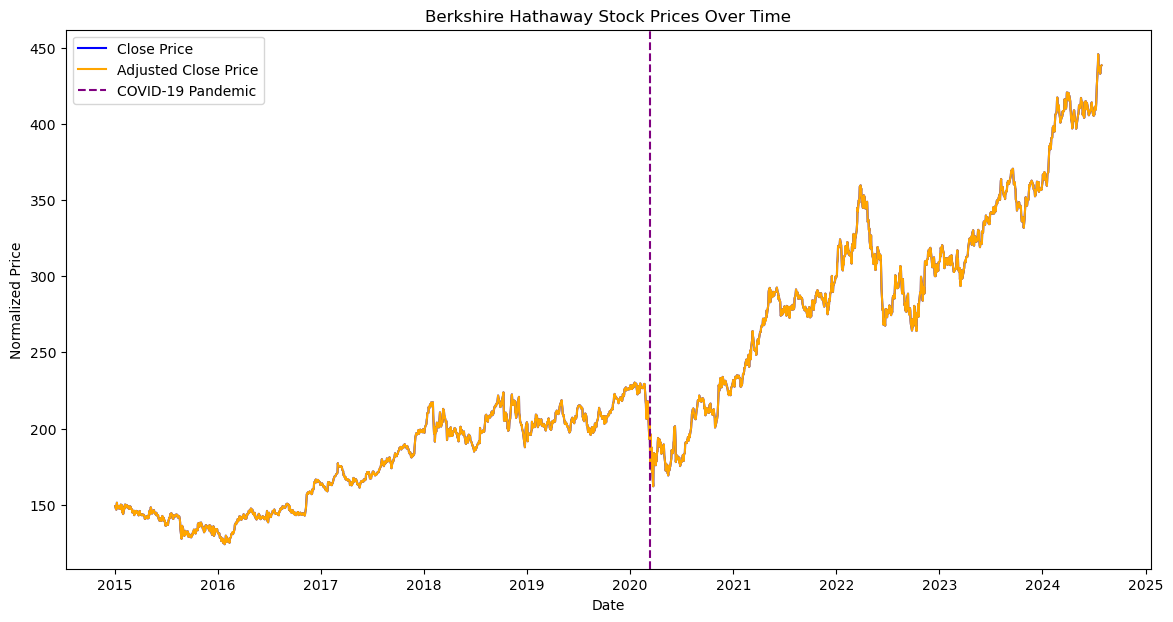

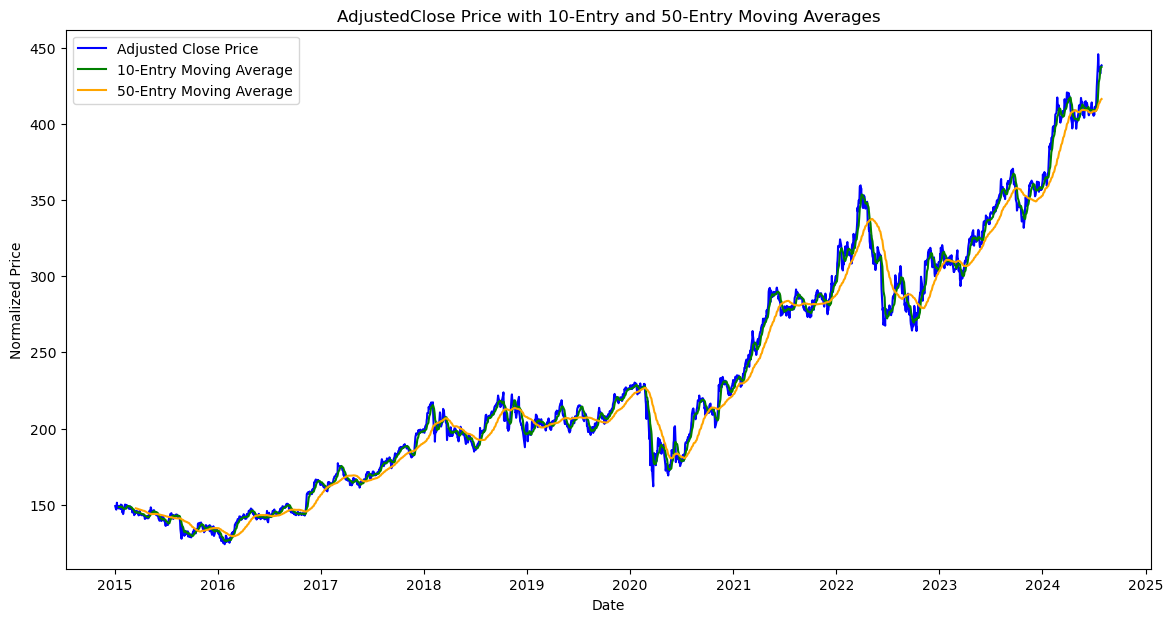

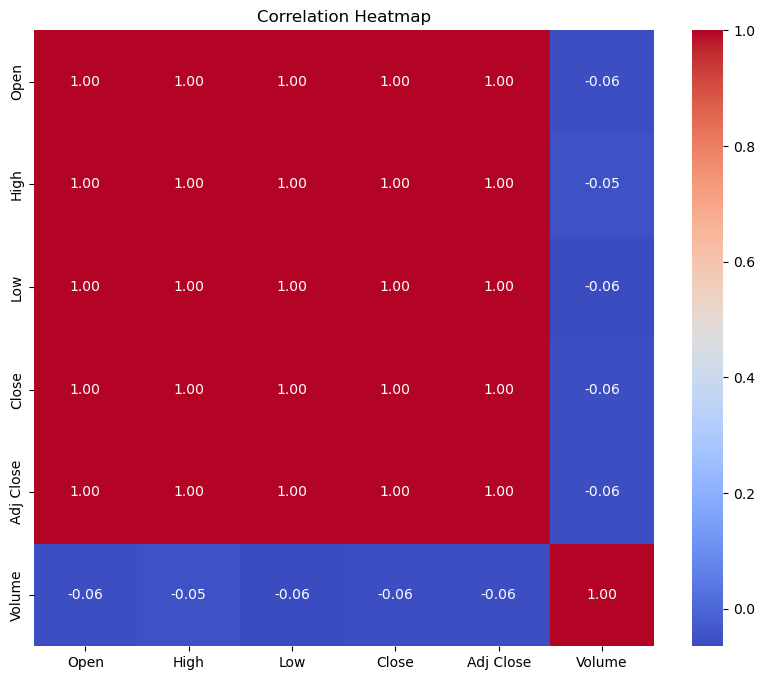

In [63]:
# Faithful Odoi

file_path = './berkshire_hathaway_data.csv'

df = pd.read_csv(file_path)

# Convert 'Date' to datetime format for time series plotting
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 1. Line Plot of Close and Adjusted Close Prices Over Time with Annotations
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='orange')
plt.axvline(pd.Timestamp('2020-03-11'), color='purple', linestyle='--', label='COVID-19 Pandemic')
plt.title("Berkshire Hathaway Stock Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# 2. Moving Average Plot (10-entry and 50-entry) for Adjusted Close Price
df['Adj Close_10_entry_MA'] = df['Adj Close'].rolling(window=10).mean()
df['Adj Close_50_entry_MA'] = df['Adj Close'].rolling(window=50).mean()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='blue')
plt.plot(df.index, df['Adj Close_10_entry_MA'], label='10-Entry Moving Average', color='green')
plt.plot(df.index, df['Adj Close_50_entry_MA'], label='50-Entry Moving Average', color='orange')
plt.title("AdjustedClose Price with 10-Entry and 50-Entry Moving Averages")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

# 3. Correlation Heatmap for Stock Prices and Volume
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

### Pre-process the dataset
Use Min-Max Scaling to ensure the values magnitude does not contribute to their relative weights.

### Plot outliers in volume before and after logarithmic scaling
Logarithmic scalling helped mitigate the influence of outliers by scaling the data. But there are still some extraneous outliers that need to be removed.

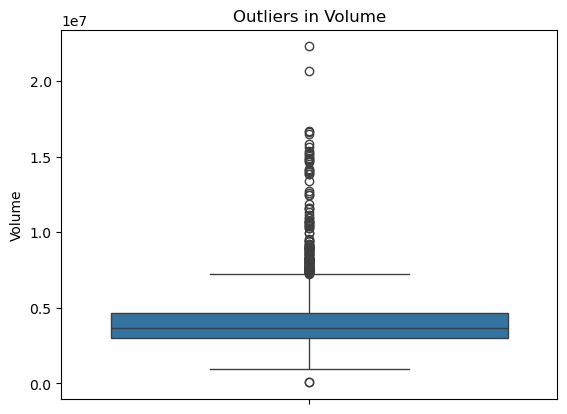

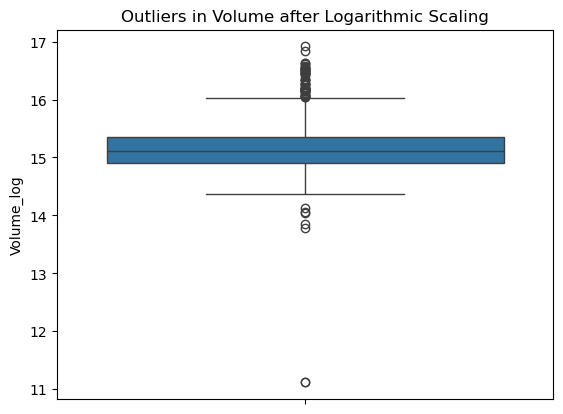

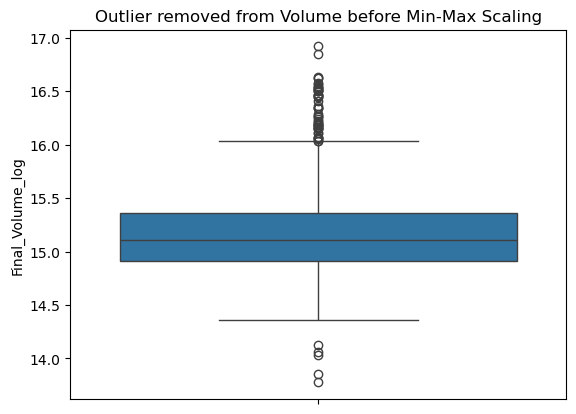

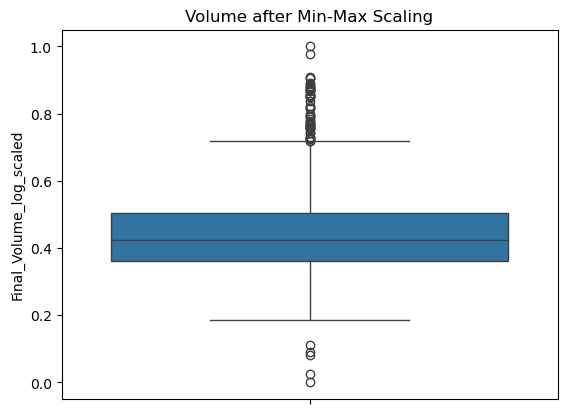

In [64]:
# Gabe Lapham

# No empty values so the following lines aren't necessary
# print(df.isnull().sum())
# df.ffill(inplace=True)

# Using adjusted close instead of close because it predicts market trends while removing some of the external noise
df.drop('Close', axis=1)

# Before scaling save a copy of the dataframe to use for tree-based models
df_copy = df.copy()

sns.boxplot(data=df['Volume'])
plt.title(f"Outliers in Volume")
plt.show()

# Logarithmic Scaling for Volume
df['Volume_log'] = np.log1p(df['Volume'])  # log1p handles zero values effectively

sns.boxplot(data=df['Volume_log'])
plt.title(f"Outliers in Volume after Logarithmic Scaling")
plt.show()

# remove extraneous outliers
mean_value = df['Volume_log'].mean()
threshold = 0.25 * mean_value
lower_bound = mean_value - threshold
upper_bound = mean_value + threshold
df['Final_Volume_log'] = df['Volume_log'][
    (df['Volume_log'] >= lower_bound) & (df['Volume_log'] <= upper_bound)
]

sns.boxplot(data=df['Final_Volume_log'])
plt.title(f"Outlier removed from Volume before Min-Max Scaling")
plt.show()

# Min-Max Scaling for all parameters
scaler = MinMaxScaler()
parameter_columns = [
    'Open', 'High', 'Low', 'Adj Close', 
]
df[parameter_columns] = scaler.fit_transform(df[parameter_columns])
df['Final_Volume_log_scaled'] = scaler.fit_transform(df['Final_Volume_log'].values.reshape(-1, 1))  # Reshape to 2D

sns.boxplot(data=df['Final_Volume_log_scaled'])
plt.title(f"Volume after Min-Max Scaling")
plt.show()

# Drop rows with missing values caused by lagging
df = df.dropna()
# print(df.isnull().sum())

### Split the data and train the mode

In [65]:
# Faithful Odoi

# Set features and label
def create_lag_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'Adj_Close_lag_{i}'] = df['Adj Close'].shift(i)
        df[f'Volume_lag_{i}'] = df['Final_Volume_log_scaled'].shift(i)
    return df.dropna()

lag = 5
df = create_lag_features(df, lag)
# Features are the Open, High, Low, Adj Close, and Volume from the previous {lag} number of entries
# and the moving 10 and 50 entry averages
X = df.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Volume_log', 'Final_Volume_log', 'Final_Volume_log_scaled'
]
) # dropping the old open, high, low, close, and volume values and the target value
print(X.columns)
y = df['Adj Close']

# Not using a random train test split to avoid data leakage in time-series data
split_index = int(len(X) * 0.8)
# Splitting with 50 entry lag to avoid the lagging causing a data leakage in the test data
X_train, X_test = X[:split_index], X[split_index + 50:]
y_train, y_test = y[:split_index], y[split_index + 50:]

Index(['Adj Close_10_entry_MA', 'Adj Close_50_entry_MA', 'Adj_Close_lag_1',
       'Volume_lag_1', 'Adj_Close_lag_2', 'Volume_lag_2', 'Adj_Close_lag_3',
       'Volume_lag_3', 'Adj_Close_lag_4', 'Volume_lag_4', 'Adj_Close_lag_5',
       'Volume_lag_5'],
      dtype='object')


### Validate the model results
- Linear models show overfitting likely because the test data shares too much similarity with the training data, making the model appear more accurate than it truly is.
- Even after applying Ridge regularization the model still seems to be overfitting based on the graph and the high R² score.
- K-fold cross-validation cannot be used for time series data because it assumes that observations are independent of each other.
- Using a time series sensitive cross validation
- Using SHAP for each model to assign importance values to each model


Linear Regression Results:
	Mean Squared Error (MSE): 8.612101542634416e-05
	R² Score: 0.9942794328605772
Bias: 0.02
Variance: 0.01


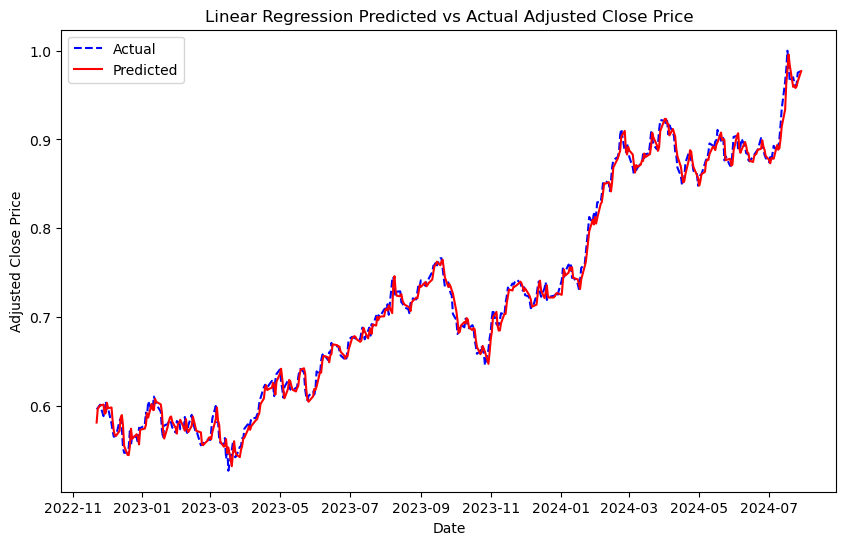

In [66]:
# Triton Eden

model = LinearRegression()

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Linear Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Linear Regression Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

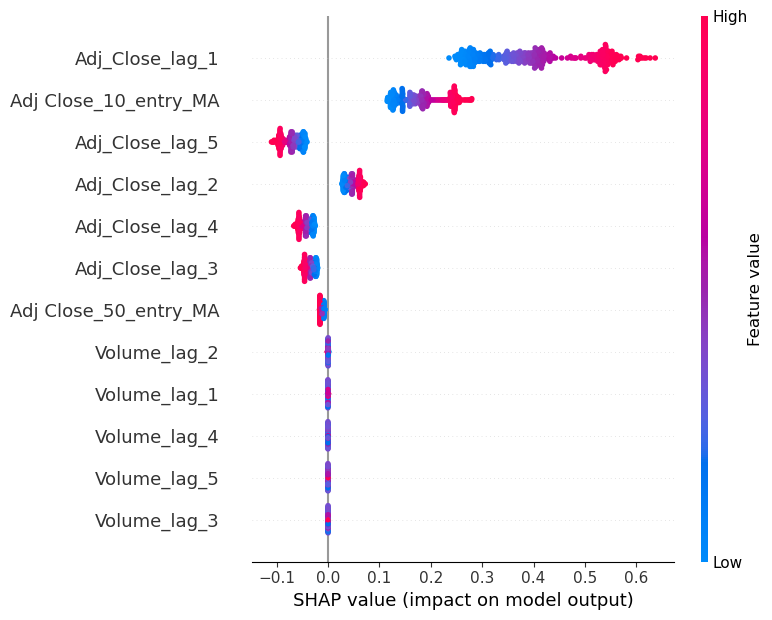

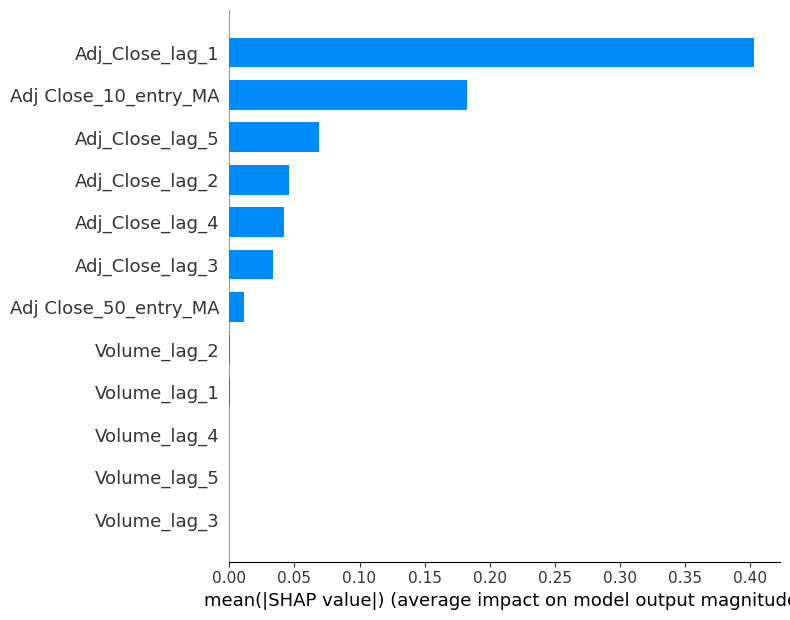

In [ ]:
# Triton Eden

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


Ridge Regression Results:
	Mean Squared Error (MSE): 0.00026834510360512754
	R² Score: 0.9821752428938626
Bias: 0.02
Variance: 0.01


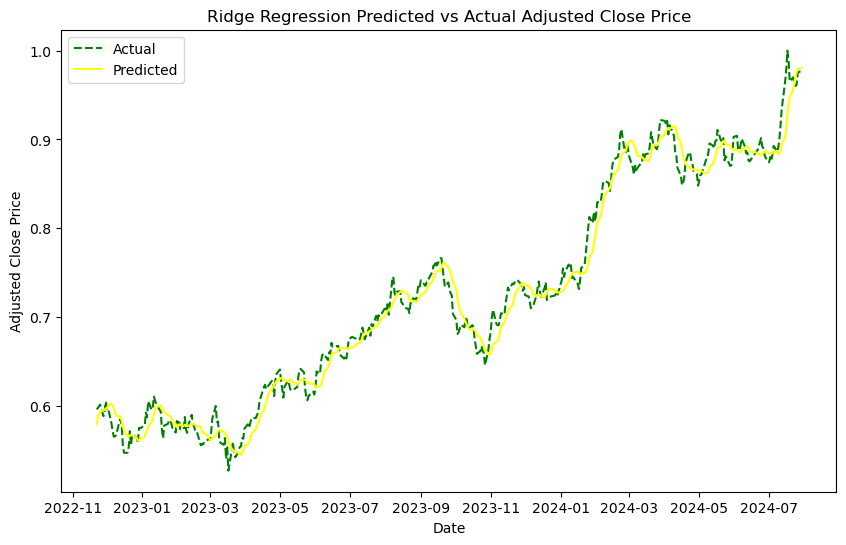

In [ ]:
# Triton Eden

model = Ridge(alpha=10.0)  # alpha is the regularization strength
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Ridge Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='green', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='yellow')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Ridge Regression Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

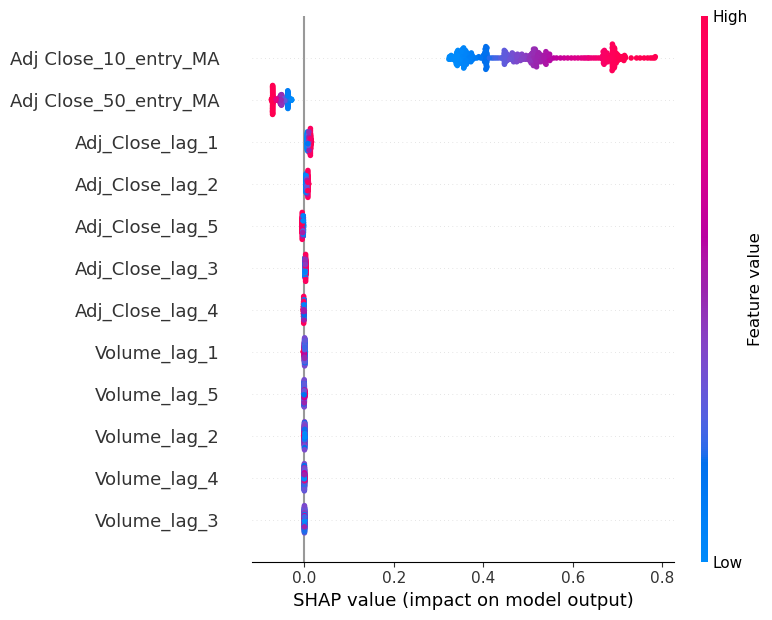

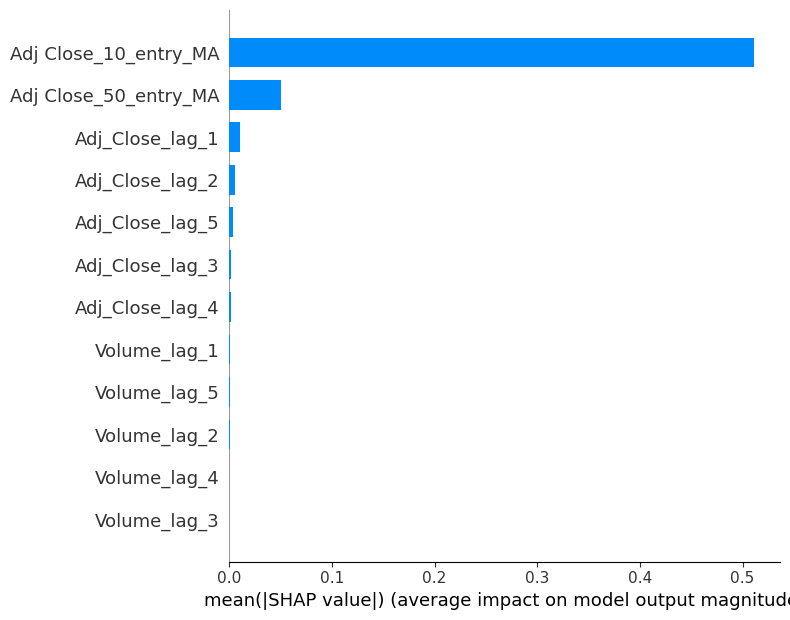

In [ ]:
# Triton Eden

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


In [ ]:
# Triton Eden

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

model = LinearRegression()

mse_scores = []
r2_scores = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_cv, y_train_cv)
    
    predictions_cv = model.predict(X_test_cv)
    
    mse = mean_squared_error(y_test_cv, predictions_cv)
    r2 = r2_score(y_test_cv, predictions_cv)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average metrics across all splits
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Time-Aware Cross-Validation Results:")
print(f"Average Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"Average R² Score: {mean_r2:.4f}")

Time-Aware Cross-Validation Results:
Average Mean Squared Error (MSE): 0.0001
Average R² Score: 0.9706


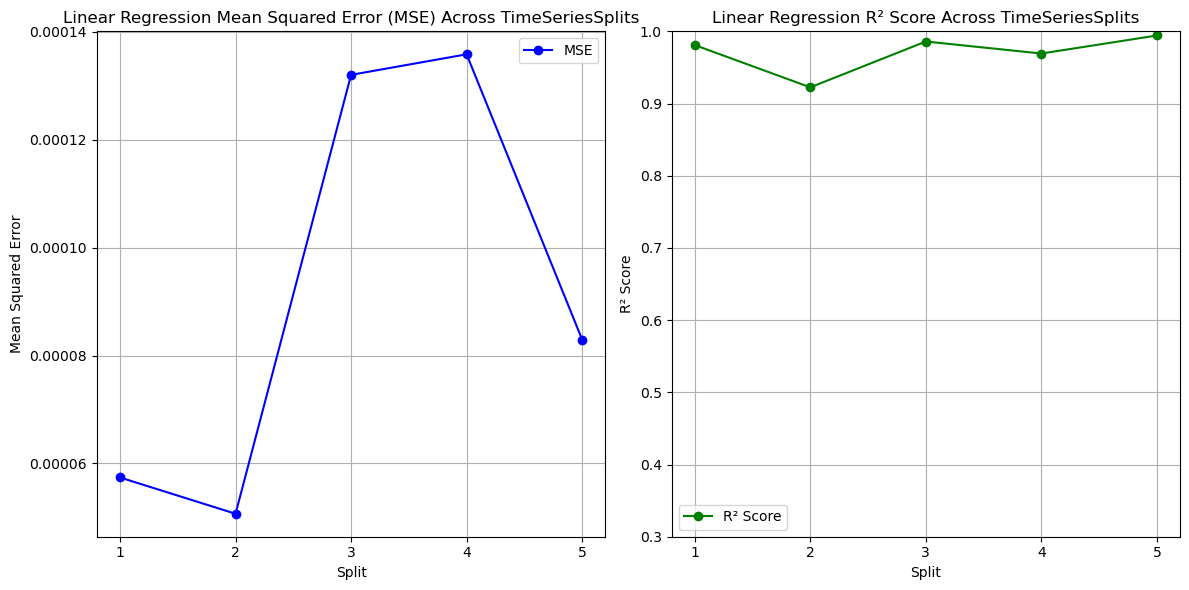

In [ ]:
# Triton Eden

# TimeSeriesSplit Cross-Validation Metrics
splits = np.arange(1, n_splits + 1)

# Plotting MSE scores across splits
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(splits, mse_scores, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Linear Regression Mean Squared Error (MSE) Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error')
plt.xticks(splits)
plt.grid(True)
plt.legend()

# Plotting R² scores across splits
plt.subplot(1, 2, 2)
plt.plot(splits, r2_scores, marker='o', linestyle='-', color='green', label='R² Score')
plt.title('Linear Regression R² Score Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('R² Score')
plt.xticks(splits)
plt.grid(True)
plt.legend()
plt.ylim(0.3, 1.0)

plt.tight_layout()
plt.show()


In [ ]:
# Triton Eden

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

model = Ridge(alpha=10.0)

mse_scores = []
r2_scores = []

# Perform TimeSeriesSplit cross-validation
for train_index, test_index in tscv.split(X):
    # Split the data into training and testing sets
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train_cv, y_train_cv)
    
    predictions_cv = model.predict(X_test_cv)
    
    mse = mean_squared_error(y_test_cv, predictions_cv)
    r2 = r2_score(y_test_cv, predictions_cv)
    
    mse_scores.append(mse)
    r2_scores.append(r2)

# Calculate average metrics across all splits
mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Time-Aware Cross-Validation Results:")
print(f"Average Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"Average R² Score: {mean_r2:.4f}")

Time-Aware Cross-Validation Results:
Average Mean Squared Error (MSE): 0.0003
Average R² Score: 0.9182


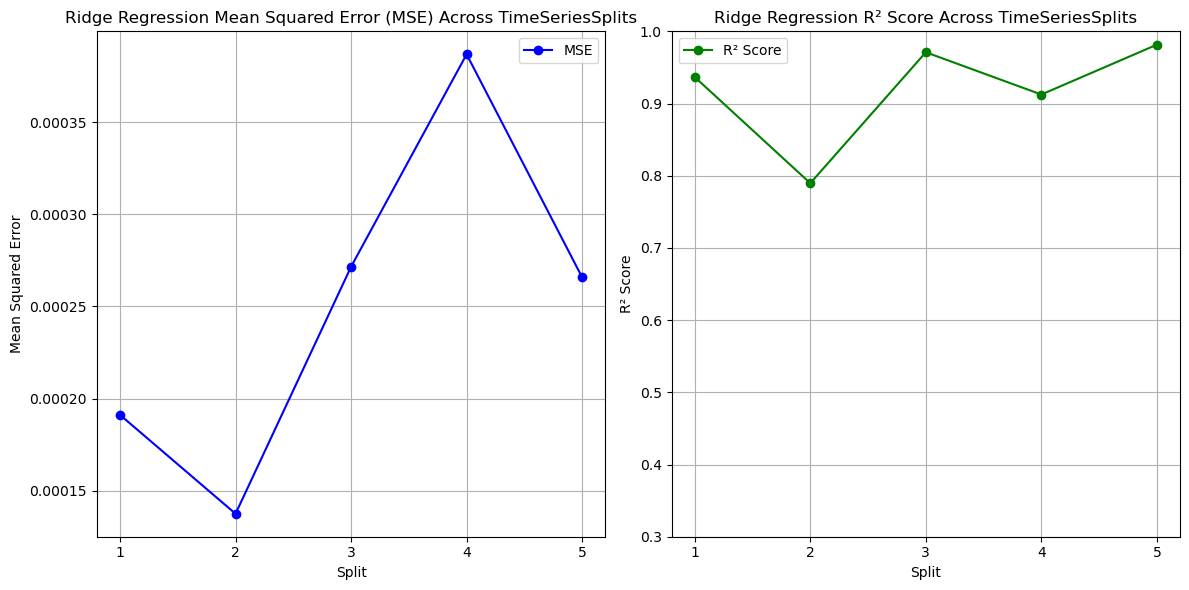

In [ ]:
# Triton Eden

# TimeSeriesSplit Cross-Validation Metrics
splits = np.arange(1, n_splits + 1)

# Plotting MSE scores across splits
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(splits, mse_scores, marker='o', linestyle='-', color='blue', label='MSE')
plt.title('Ridge Regression Mean Squared Error (MSE) Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error')
plt.xticks(splits)
plt.grid(True)
plt.legend()

# Plotting R² scores across splits
plt.subplot(1, 2, 2)
plt.plot(splits, r2_scores, marker='o', linestyle='-', color='green', label='R² Score')
plt.title('Ridge Regression R² Score Across TimeSeriesSplits')
plt.xlabel('Split')
plt.ylabel('R² Score')
plt.xticks(splits)
plt.grid(True)
plt.legend()
plt.ylim(0.3, 1.0)

plt.tight_layout()
plt.show()

#### Tree-based models
- Not generally good for time series data
- No need for feature scaling

Random Forest Regression Results:
	Mean Squared Error (MSE): 1279.724046765346
	R² Score: 0.17819527262503365
Bias: 2,059.99
Variance: 264.92


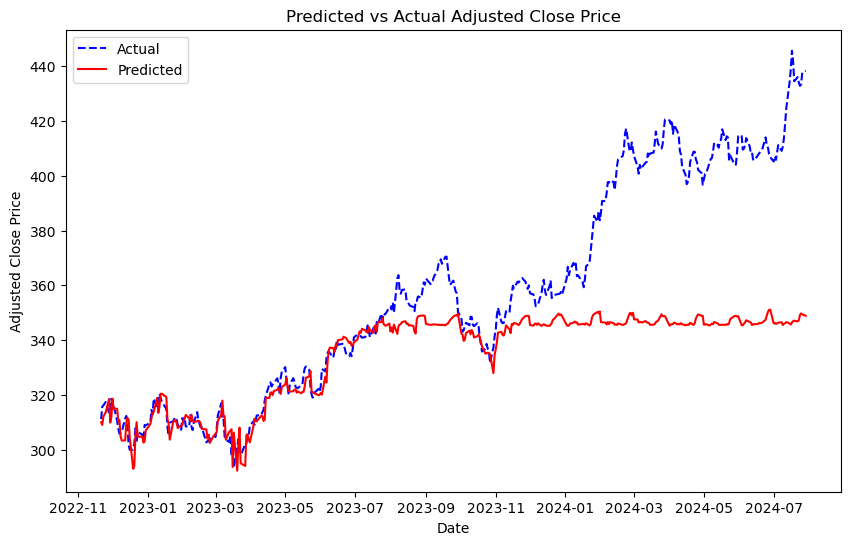

In [ ]:
# Triton Eden

# Get parameters for the tree-based models
def create_lag_features(df, lag=1):
    for i in range(1, lag + 1):
        df[f'Adj_Close_lag_{i}'] = df['Adj Close'].shift(i)
        df[f'Volume_lag_{i}'] = df['Volume'].shift(i)
    return df.dropna()

lag = 5
df_copy = create_lag_features(df_copy, lag)
# Features are the Open, High, Low, Adj Close, and Volume from the previous {lag} number of entries
# and the moving 10 and 50 entry averages
X = df_copy.drop(columns=[
    'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
]
) # dropping the old open, high, low, close, and volume values and the target value
# Add date-related features
X['year'] = X.index.year
X['month'] = X.index.month
X['day'] = X.index.day
X['day_of_week'] = X.index.dayofweek
X['quarter'] = X.index.quarter
X['is_month_end'] = X.index.is_month_end.astype(int)
X['is_month_start'] = X.index.is_month_start.astype(int)
y = df_copy['Adj Close']

# Not using a random train test split to avoid data leakage in time-series data
split_index = int(len(X) * 0.8)
# Splitting with 50 entry lag to avoid the lagging causing a data leakage in the test data
X_train, X_test = X[:split_index], X[split_index + 50:]
y_train, y_test = y[:split_index], y[split_index + 50:]

model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Random Forest Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

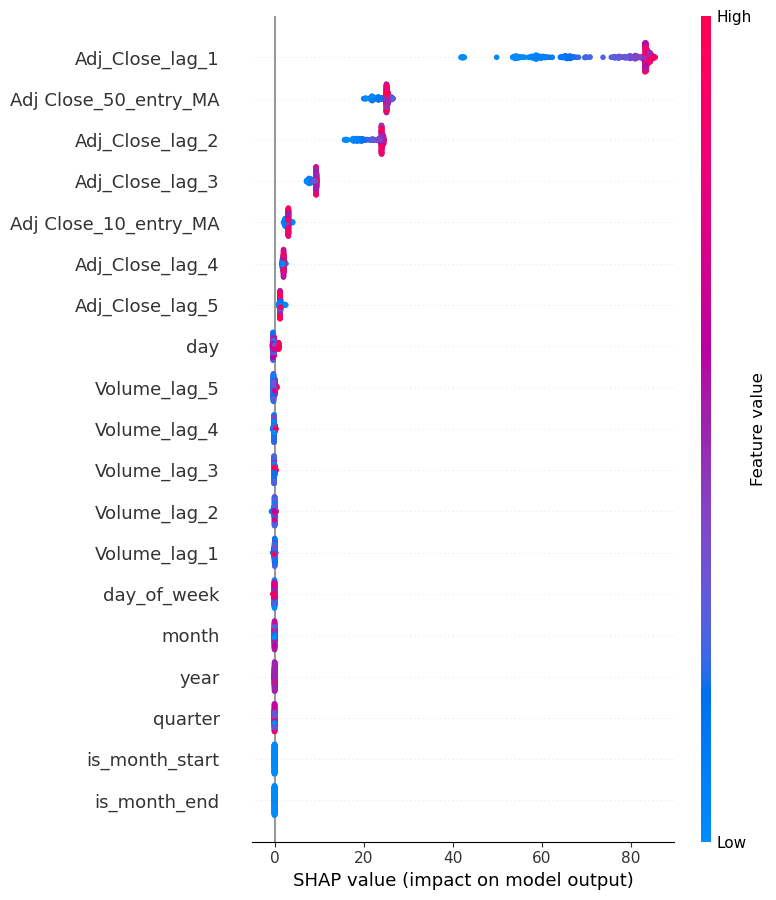

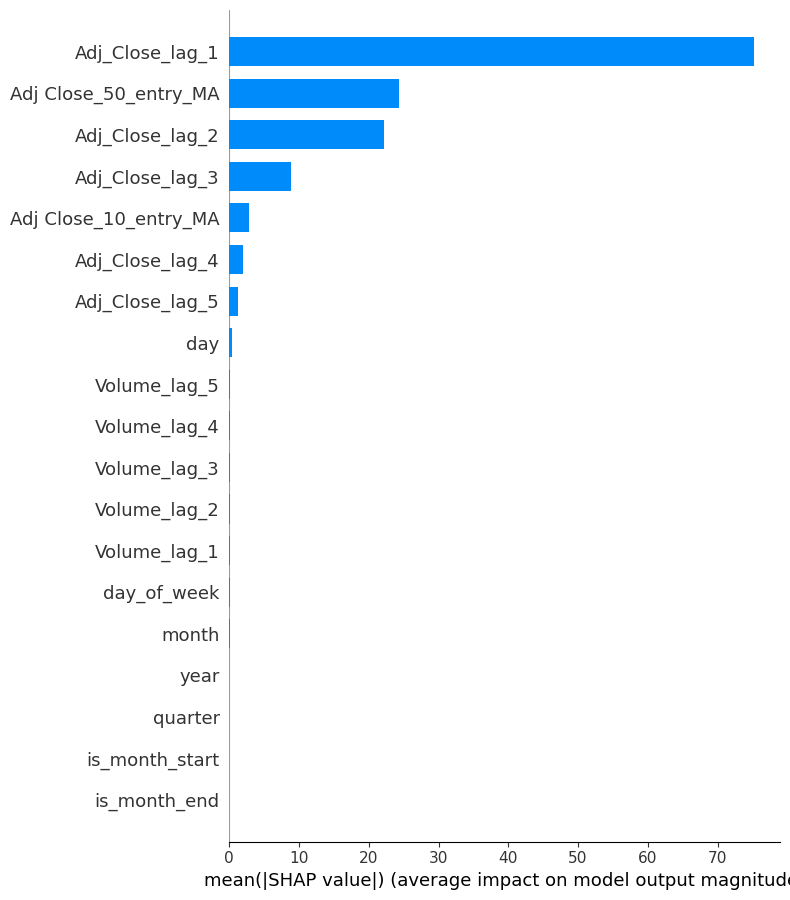

In [ ]:
# Triton Eden

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


Random Forest Regression Results:
	Mean Squared Error (MSE): 1545.8084857256542
	R² Score: 0.007322926847668665
Bias: 2,194.67
Variance: 203.53


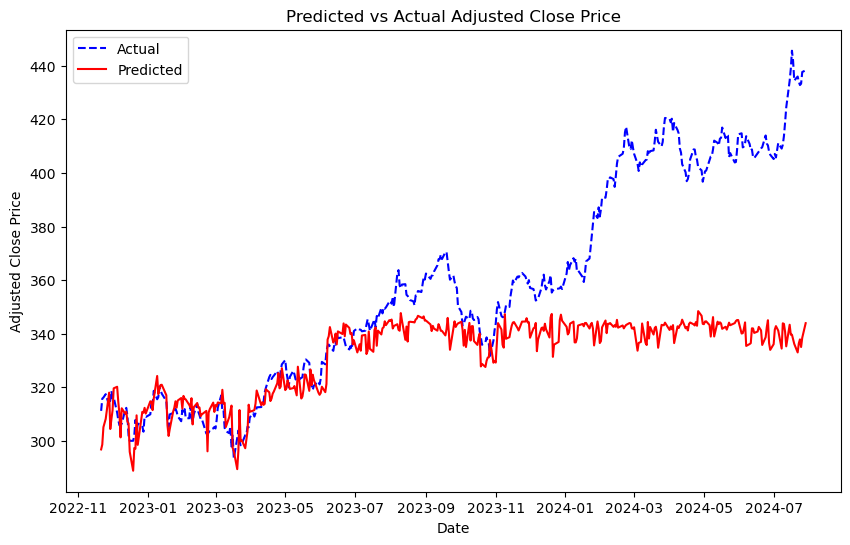

In [ ]:
# Triton Eden

model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate = 0.5)

# Train the model and fit to the test set
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"Random Forest Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

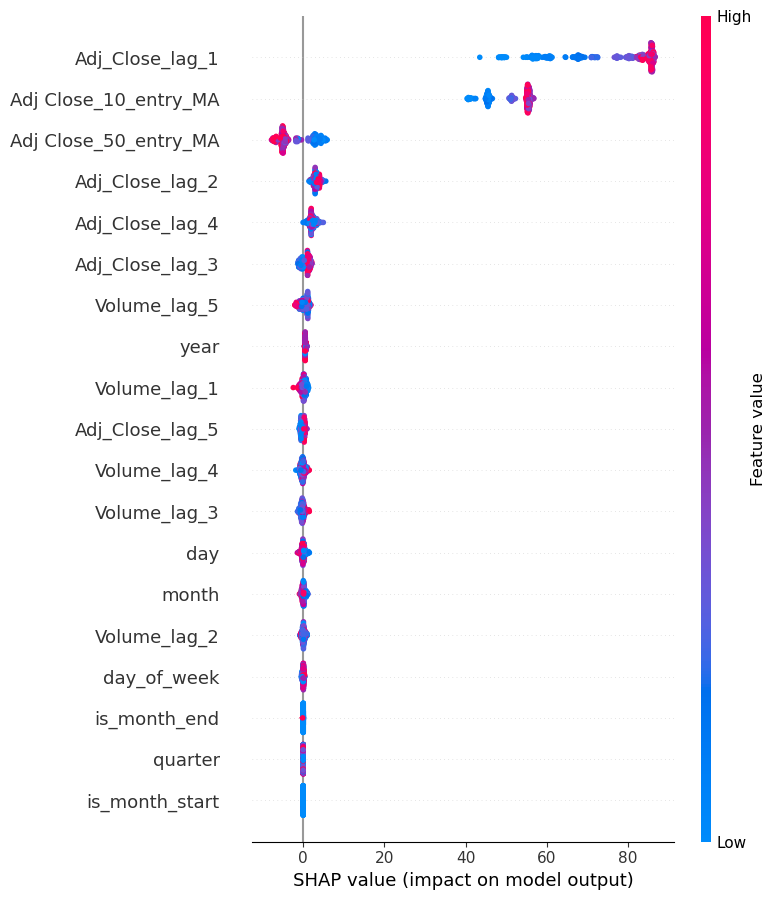

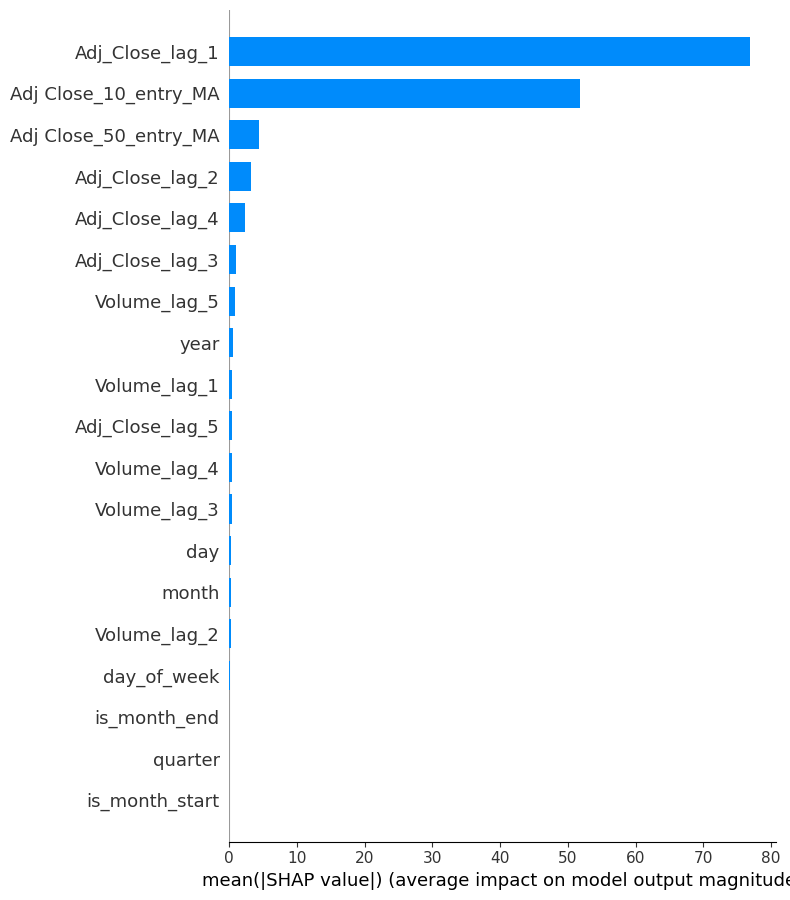

In [ ]:
# Triton Eden

# Initialize SHAP Explainer
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


In [ ]:
# Triton Eden

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.3, max_depth=10, min_child_weight=1, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, min_child_weight=5, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, min_child_weight=1, subsample=0.6; total time=   0.

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
XGBoost Regression Results:
	Mean Squared Error (MSE): 1288.0490073008416
	R² Score: 0.17284920450935426
Bias: 2,102.90
Variance: 259.51


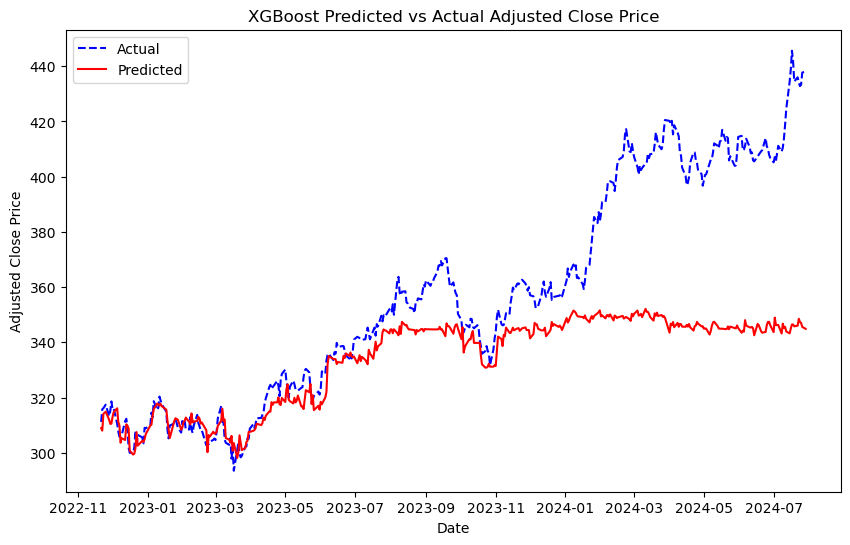

In [ ]:
# Triton Eden

# Train the model and fit to the test set
print(best_model)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
# Print results
print(f"XGBoost Regression Results:\n\tMean Squared Error (MSE): {mse}\n\tR² Score: {r2}")

# Calculate the mean of the predictions (expected prediction)
mean_prediction = np.mean(predictions)

# Calculate bias
bias = np.mean((y_test - mean_prediction) ** 2)
print(f"Bias: {bias:,.2f}")

# Calculate variance
variance = np.mean((predictions - mean_prediction) ** 2)
print(f"Variance: {variance:,.2f}")

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual', color='blue', linestyle='--')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('XGBoost Predicted vs Actual Adjusted Close Price')
plt.legend()
plt.show()

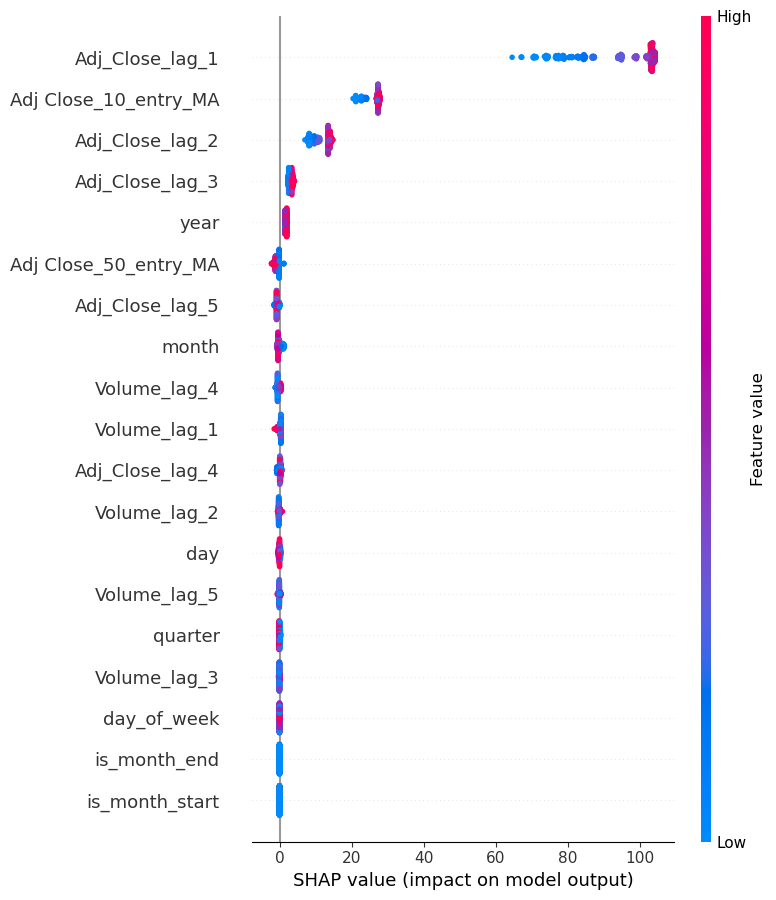

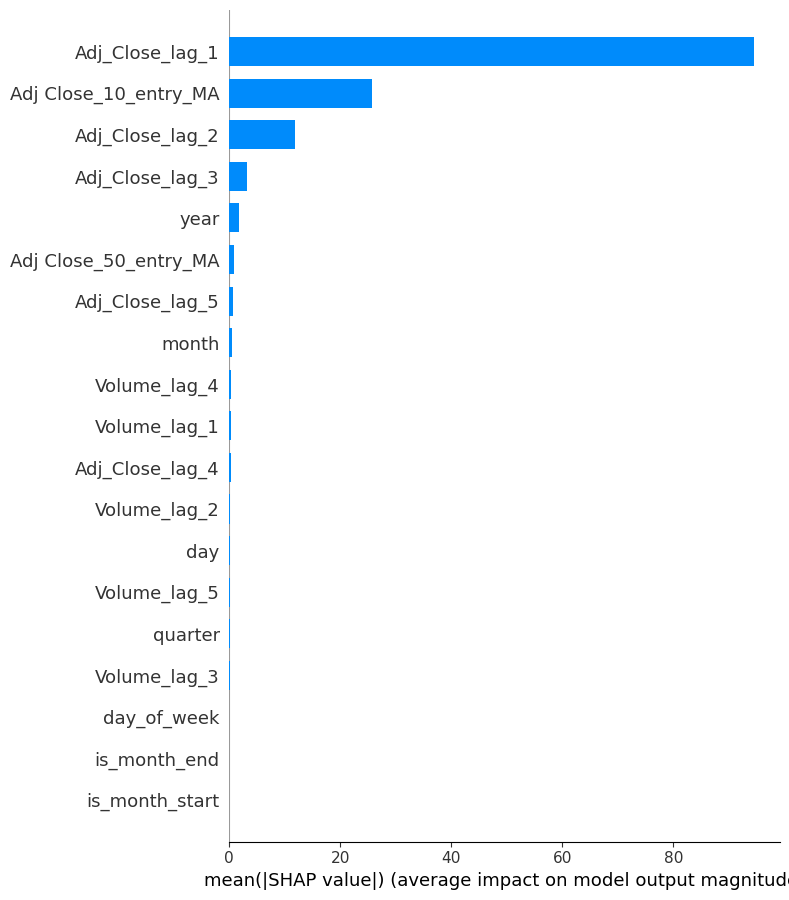

In [ ]:
# Triton Eden

# Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot of SHAP values
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Bar plot of mean absolute SHAP values (global feature importance)
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")


#### Final Results
- SHAP values indicate that the volume values do not contribute much to the result and can be removed if the model needs to be more lightweight
- The linear regression performs the best of all of the models
- The tree-based model aren't able to capture the full extent of the long-term growth even after hyper parameter tuning